In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from rubin_sim.utils import angular_separation
from rubin_sim.moving_objects import PyOrbEphemerides

In [2]:
# Let's try loading up one of our things and naming things approp
gran = pd.read_csv('/Users/yoachim/rubin_sim_data/orbits/granvik_5k.txt', sep=' ')

In [17]:
gran

,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H,MOID,objId,g,sed_filename
0,1.810322,0.457012,8.524691,321.309082,218.878296,194.936127,59853.0,24.902994,0.031219,242880,0.15,S.dat
1,1.390497,0.458398,43.303799,232.109802,241.479919,91.117035,59853.0,24.474217,0.121781,175331,0.15,S.dat
2,1.657430,0.493258,5.164651,302.836609,266.812195,161.882599,59853.0,23.124664,0.006973,647396,0.15,S.dat
3,2.073438,0.554929,10.493196,185.436066,139.102676,261.443756,59853.0,24.706829,0.085103,492747,0.15,S.dat
4,1.338621,0.133787,39.041023,341.855743,186.264435,40.988487,59853.0,24.607513,0.168620,546031,0.15,S.dat
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.624333,0.446512,54.509521,355.366943,314.864990,99.870674,59853.0,23.640100,0.114199,23696,0.15,S.dat
4996,2.984417,0.763269,41.823479,333.647278,74.136383,7.006821,59853.0,24.729494,0.234624,33632,0.15,C.dat
4997,1.787739,0.404088,23.665245,351.980927,102.490379,126.487000,59853.0,24.963896,0.084646,214385,0.15,S.dat
4998,2.174124,0.421286,4.020179,38.037006,138.996429,290.406464,59853.0,24.503445,0.267403,106108,0.15,S.dat


In [3]:
mjds = 60676 + np.arange(3560)

In [4]:
oo = PyOrbEphemerides()

In [21]:
oo._convert_to_oorb_elem(gran.iloc[200:201], 'KEP')

In [22]:
two_body_ephems = oo.generate_ephemerides(mjds, eph_mode='2body')
n_body_ephems = oo.generate_ephemerides(mjds, eph_mode='nbody')


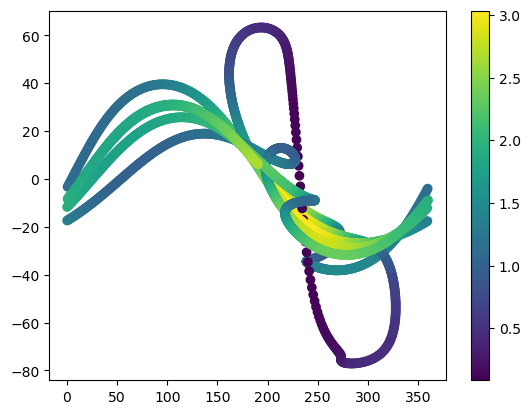

In [34]:
plt.scatter(two_body_ephems['ra'][0],
                          two_body_ephems['dec'][0], c=two_body_ephems['geo_dist'][0])
plt.colorbar()

In [24]:
diff = angular_separation(two_body_ephems['ra'],
                          two_body_ephems['dec'], n_body_ephems['ra'], n_body_ephems['dec'])

Text(0.5, 0, 'time (days)')

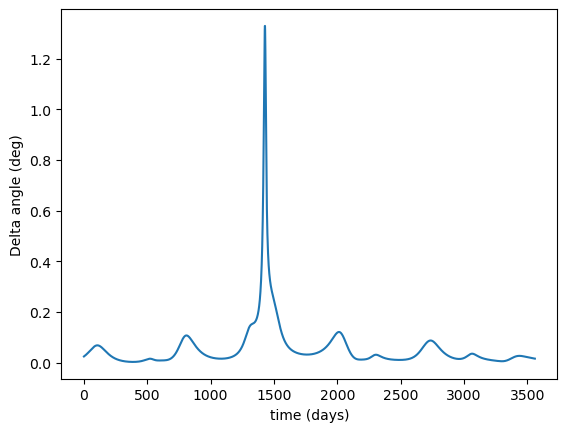

In [25]:
ack = plt.plot(diff)
plt.ylabel('Delta angle (deg)')
plt.xlabel('time (days)')

In [13]:
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import CartesianRepresentation, SkyCoord, EarthLocation, SkyCoord, AltAz

In [36]:
from poliastro.core.angles import (
    D_to_nu as D_to_nu_fast,
    E_to_nu as E_to_nu_fast,
    F_to_nu as F_to_nu_fast,
    M_to_D as M_to_D_fast,
    M_to_E as M_to_E_fast,
    M_to_F as M_to_F_fast,
)

def true_anomaly_from_mean_poliastro_fast(ecc, M):
    ecc, M = ecc.value, M.to(u.rad).value
    if ecc < 1:
        M = (M + np.pi) % (2 * np.pi) - np.pi
        return E_to_nu_fast(M_to_E_fast(M, ecc), ecc) * u.rad
    elif ecc == 1: 
        return D_to_nu_fast(M_to_D_fast(M)) * u.rad
    else: 
        return F_to_nu_fast(M_to_F_fast(M, ecc), ecc) * u.rad

In [37]:
params=gran.iloc[200]

nu = true_anomaly_from_mean_poliastro_fast(params['e']*u.one, params['Omega']*u.deg)

orb = Orbit.from_classical(Sun, params['a']*u.AU, params['e']*u.one, params['inc']*u.deg,
                           nu, params['argPeri']*u.deg, params['meanAnomaly']*u.deg)

In [38]:
times = Time(mjds, format='mjd')
ephem = orb.to_ephem(strategy=EpochsArray(epochs=times))
cart = ephem.sample()

In [39]:
c = SkyCoord(cart.x, cart.y, cart.z,
             representation_type='cartesian', obstime=times)
from_earth = c.gcrs

Text(0, 0.5, 'dec')

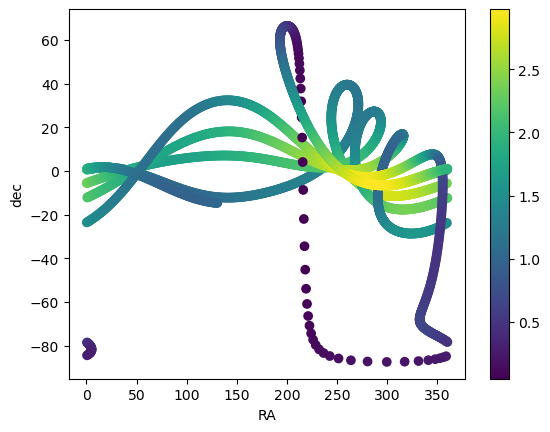

In [40]:
plt.scatter(from_earth.ra, from_earth.dec, c=from_earth.distance.to(u.au))
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('dec')

rec.array([[(60676., 302.95703742, -29.90721565, 0.72534998,  0.14436053, 14.67524352, 20.45846724, 1.35687207, 2.23392374, 28.18843922, 258.39489549, 0.73957593),
            (60677., 303.79540814, -29.76312588, 0.72849412,  0.14972314, 14.58306746, 20.23385658, 1.35088885, 2.23001356, 28.17189568, 258.99580431, 0.74372085),
            (60678., 304.63614617, -29.61364377, 0.73162416,  0.15512928, 14.4932105 , 20.01366172, 1.34489334, 2.22603309, 28.15528898, 259.60206568, 0.7478897 ),
            ...,
            (64233., 189.32873817,   6.72331669, 0.55408644, -0.26835403,  5.9130112 ,  9.97178384, 1.68461264, 2.66272543, 28.69604328, 130.77300934, 0.61565061),
            (64234., 189.88419145,   6.45604236, 0.55232022, -0.26726551,  5.85414853,  9.90205633, 1.68922023, 2.66741807, 28.70281103, 131.15999447, 0.61358657),
            (64235., 190.4375615 ,   6.18983986, 0.55059326, -0.26616215,  5.80284913,  9.84449545, 1.69380078, 2.67202336, 28.70981879, 131.54488059, 0.6115515 )]

In [35]:
help(Orbit.from_classical)

Help on method from_classical in module poliastro.twobody.orbit.creation:

from_classical(attractor, a, ecc, inc, raan, argp, nu, epoch=<Time object: scale='tt' format='jyear_str' value=J2000.000>, plane=<Planes.EARTH_EQUATOR: 'Earth mean Equator and Equinox of epoch (J2000.0)'>) method of builtins.type instance
    Return `Orbit` from classical orbital elements.
    
    Parameters
    ----------
    attractor : Body
        Main attractor.
    a : ~astropy.units.Quantity
        Semi-major axis.
    ecc : ~astropy.units.Quantity
        Eccentricity.
    inc : ~astropy.units.Quantity
        Inclination
    raan : ~astropy.units.Quantity
        Right ascension of the ascending node.
    argp : ~astropy.units.Quantity
        Argument of the pericenter.
    nu : ~astropy.units.Quantity
        True anomaly.
    epoch : ~astropy.time.Time, optional
        Epoch, default to J2000.
    plane : ~poliastro.frames.Planes
        Fundamental plane of the frame.

